In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import os
from tqdm import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import numpy as np
%matplotlib inline

## Готовим данные
Три файла с данными
1. исторические данные - train
2. Тестовые данные текущего момента - derived
3. Пример сабмита резкльтатов конкурса на кагле

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

CONTENT_DIR = "drive/MyDrive/nn/data/rnn/"

Mounted at /content/drive


In [ ]:
def read_set(file):
    data = pd.read_csv(file)
    data['date'] = pd.to_datetime(data['date'])
    data = data.rename(columns = {'DATE':'date'})
    data = data.rename(columns = {'hits':'value'})
    data = data.set_index('date')
    return data

In [ ]:
data_train = read_set(CONTENT_DIR + 'train.csv')
data_test =  read_set(CONTENT_DIR + 'derived.csv')
data_sample = read_set(CONTENT_DIR + 'sample_submission.csv')

In [ ]:
data_sample.describe()

,value
count,365.0
mean,110355560.0
std,0.0
min,110355560.0
25%,110355560.0
50%,110355560.0
75%,110355560.0
max,110355560.0


## Графики наших временных последовательностей

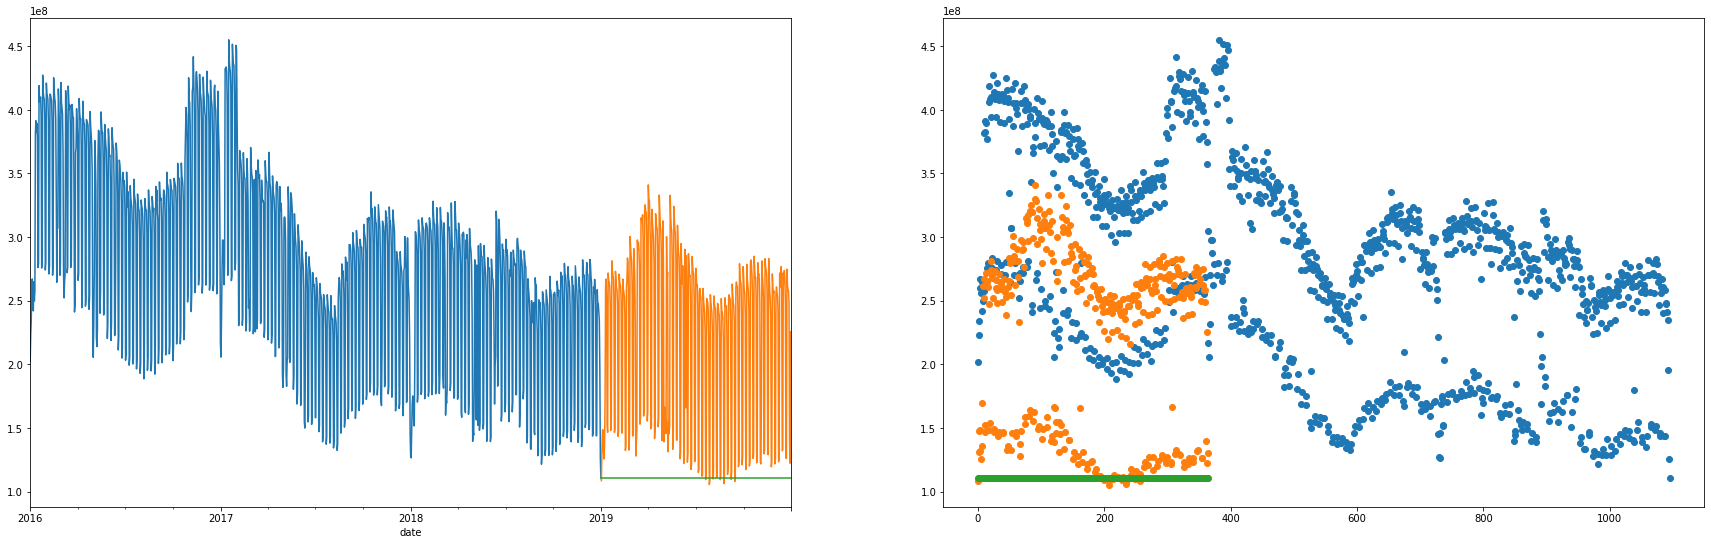

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(30, 9))
data_train['value'].plot(kind = 'line', ax=ax[0])
data_test['value'].plot(kind = 'line', ax=ax[0])
data_sample['value'].plot(kind = 'line', ax=ax[0])

ax[1].scatter(np.arange(data_train.shape[0]), data_train['value'].values)
ax[1].scatter(np.arange(data_test.shape[0]), data_test['value'].values)
ax[1].scatter(np.arange(data_sample.shape[0]), data_sample['value'].values)

plt.show()

## Статистическая модель [ARIMA](https://ru.wikipedia.org/wiki/ARIMA)


In [ ]:
# обучаем модель
# arima_model=model = pm.auto_arima(data_train, seasonal = True,m = 4,test='adf',error_action='ignore',  
#                            suppress_warnings=True,
#                       stepwise=True, trace=True)

In [ ]:
# prediction = pd.DataFrame(model.predict(n_periods = int(data_test.size)), data_test.index)

In [ ]:
# prediction = prediction .rename(columns = {0:'value'})

In [ ]:
# plt.figure()
# data_train['value'].plot(kind = 'line')
# data_test['value'].plot(kind = 'line')
# #plt.plot(data_forecaste, label = "Prediction")
# prediction['value'].plot(kind = 'line')
# plt.show()

### Функция подсчета метрик для конкурса

In [ ]:
def MAPE(y_true, y_pred):
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), 1e-6)
    mape  = np.average(mape) * 100
    return mape

### MAPE для ARIMA и тестового сабмишена

In [ ]:
# MAPE(data_test, prediction)

In [ ]:
# MAPE(data_test, data_sample)

## Из пандас строим датасет

In [ ]:
def running_mean_std(x, N, mean_, std_):
    x_for_mean = np.insert(x, 0, np.array([mean_] * (N - 1)).reshape(-1))
    mean = pd.Series(x_for_mean).rolling(window=N).mean().to_numpy()[N - 1:]
    std = pd.Series(x).rolling(window=N).std().to_numpy()[N - 1:]
    std = np.insert(std, 0, np.array([std_] * (N - 1)).reshape(-1))

    # cumsum = np.cumsum(np.insert(x, 0, np.array([stats.mean] * (20 + 1)).reshape(-1)))
    # mean = (cumsum[N:] - cumsum[:-N]) / float(N)
    return mean, std

In [ ]:
class Stats:
    def __init__(self, dataset):
        self.mean = np.mean(dataset)
        self.std = np.std(dataset)
        self.data = (dataset - self.mean) / self.std 

stats = Stats(data_train)

In [ ]:
class TSDataset(Dataset):
    
    def __init__(self, data, seq_len):
        super().__init__()
        # будем обучать окнами, поэтому сделаем отступ
        self._len = len(data) - seq_len + 1
        # также будем нормализовывать наши таргеты  
        self.data = data.copy()
        self.mean, self.std = running_mean_std(data.to_numpy().reshape(-1), seq_len, stats.mean, stats.std)
        self.data['value'] = (self.data.to_numpy().squeeze() - self.mean) / self.std 
        self.seq_len = seq_len
        
    def __len__(self):
        return self._len
    
    def __getitem__(self, idx):
        d = self.data[idx:idx + self.seq_len]
        targets = []
        days   = []
        months = []
        year = []
        for row in  d.iterrows():
            targets += [ row[1]['value'] ]
            days += [ row[0].day ]
            months += [row[0].month]
            year += [row[0].year]
            
        return torch.LongTensor(days), \
               torch.LongTensor(months), \
               torch.LongTensor(year), \
               torch.FloatTensor(targets)

In [ ]:
ds_train = TSDataset(data_train, 40) 
ds_test  = TSDataset(data_test, 40)

In [ ]:
ds_train[0]

(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,  4,  5,
          6,  7,  8,  9]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 tensor([2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016,
         2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016,
         2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016,
         2016, 2016, 2016, 2016]),
 tensor([-0.9814, -0.6880, -0.5338, -0.1900, -0.0893, -0.2245, -0.3969, -0.0945,
         -0.2810, -0.1679,  1.4170,  1.5022,  1.3479,  1.4057,  1.2135, -0.1022,
         -0.0568,  1.7153,  1.5062,  1.4990,  1.4722,  1.2332, -0.3157, -0.2127,
          1.6108,  1.3974,  1.2946,  1.2388,  1.0175, -0.5496, -0.4560,  1.3182,
          1.1640,  1.0986,  1.0168,  0.7548, -0.7993, -0.7105,  0.999

## Теперь нужно определить нашу модель 

In [ ]:

class TimeSeriesModel(nn.Module):
    
        def __init__(self, hidden_size, input_sizes):            
            super().__init__()
            self.months = nn.Embedding(12 + 1, input_sizes[0])
            self.days = nn.Embedding(31 + 1, input_sizes[1])
            self.rnn = nn.LSTM(np.sum(input_sizes) + 1, hidden_size=hidden_size, batch_first=True)
            self.out = nn.Linear(hidden_size, 1)
            
        def forward(self, batch):
            days, mons, _, targets = batch
            mon_tensor = self.months(mons)
            day_tensor = self.days(days)
            rnn_input  = torch.cat([mon_tensor, day_tensor], dim=-1)
            targets = targets.unsqueeze(-1)
            rnn_input = torch.cat([rnn_input, targets ], dim=-1)
            rnn_input = rnn_input[:, :-1, :]
            print(rnn_input.shape)
            print(rnn_input)
            output, ctx = self.rnn(rnn_input, None)
            output = self.out(output).squeeze()
                
            # возвращаем выход и контекст
            return output, ctx
        

        def _increment_forward(self, rnn_input, prev_output, ctx):
            '''incremental'''
            days, mons = rnn_input
            mon_tensor = self.months(mons)
            day_tensor = self.days(days)

            input_rnn = torch.cat([mon_tensor, day_tensor, prev_output], dim=-1)

            output, ctx = self.rnn(input_rnn, ctx)
            output = self.out(output)

            return output, ctx

### Определяем даталоадеры для теста и трейна

In [ ]:
dl_train = DataLoader(ds_train, 8 , True)
dl_test = DataLoader(ds_test, 8 , False)

In [ ]:
series_model = TimeSeriesModel(64, (4,4))

In [ ]:
for batch in dl_train:
    # print(batch[0].shape)
    print(series_model(batch)[0].shape)
    break

torch.Size([8, 39, 9])
tensor([[[-1.9378e-01,  8.6557e-01, -1.0882e+00,  ..., -3.7985e-01,
           8.3113e-01, -1.7988e+00],
         [-1.9378e-01,  8.6557e-01, -1.0882e+00,  ..., -1.6507e+00,
          -1.1420e+00, -1.6763e+00],
         [-1.9378e-01,  8.6557e-01, -1.0882e+00,  ...,  4.4962e-01,
           1.3994e+00,  6.4327e-01],
         ...,
         [-8.2616e-01, -7.8884e-02,  7.3289e-01,  ...,  1.1004e+00,
           1.3399e+00, -1.3386e+00],
         [-8.2616e-01, -7.8884e-02,  7.3289e-01,  ...,  3.3926e-02,
           2.4537e-01,  6.6611e-01],
         [-8.2616e-01, -7.8884e-02,  7.3289e-01,  ..., -8.1754e-01,
          -8.3543e-01,  4.8089e-01]],

        [[-3.2639e-01, -1.6946e+00,  2.2165e+00,  ..., -6.9141e-01,
          -1.2858e+00,  1.2343e+00],
         [-3.2639e-01, -1.6946e+00,  2.2165e+00,  ..., -4.8558e-01,
           1.4518e+00,  1.1535e+00],
         [-3.2639e-01, -1.6946e+00,  2.2165e+00,  ..., -3.2119e+00,
          -2.7337e-01,  9.6382e-01],
         ...,
  

In [ ]:
loss = nn.L1Loss()
optimizer = Adam(series_model.parameters(), lr=1e-4)

In [ ]:
writer = SummaryWriter(log_dir='./series_runs/')

### Обучаем модель

In [ ]:
global_epoch = 0
global_iter = 0

In [ ]:
# функция тестирование модели
def test_model(epoch):
    test_iter  = tqdm(dl_test)
    sum_loss = 0
    num_batches = 0
    for i, batch in enumerate(test_iter):
        target = batch[-1][:, 1:]
        result, _ = series_model(batch)
        batch_loss = loss(result, target)
        sum_loss += batch_loss
        num_batches += 1
    sum_loss /= num_batches
    writer.add_scalar('Loss/val', sum_loss , epoch)
    return sum_loss

In [ ]:
bebra = 1
for epoch in range(0, 70):
    epoch_iter = tqdm(dl_train)
    series_model.train()
    for batch in epoch_iter:
        optimizer.zero_grad()
        target = batch[-1][:,1:]
        if bebra == 1:
          print(batch[0].shape)
          print(batch[1].shape)
          print(batch[2].shape)
          print(batch[3].shape)

          bebra = 0
        result, _ = series_model(batch)        
        batch_loss = loss(result, target)
        batch_loss.backward()
        epoch_iter.set_description("Epoch: %04d, Iter Loss: %.4f"  %(epoch, batch_loss))
        optimizer.step()
        writer.add_scalar('Loss/train', batch_loss , global_iter)
        global_iter += 1
    # тестируем модель
    with torch.no_grad():
        series_model.eval()
        test_model(global_epoch)
    global_epoch += 1

In [ ]:
with torch.no_grad():
        series_model.eval()
        print(f"loss test = {test_model(global_epoch)}")

100%|██████████| 41/41 [00:00<00:00, 49.36it/s]

loss test = 0.2039422243833542


In [ ]:
torch.save(series_model.state_dict(), CONTENT_DIR + 'series_model20.ptx')

In [ ]:
series_model = TimeSeriesModel(64, (4,4))
series_model.load_state_dict(torch.load(CONTENT_DIR + 'series_model40.ptx'))

### TODO
Теперь нам нужно для нашего тестового сета сгенерировать результат, и сделать правильный сабмишен. В отличии от режима обучения мы не должгны использовать значения таргетов в тесте, поэтому нам придется тут реализовывать инкрементальный режим генерации сети, т.е. когда на вход подаются фичи и таргет с предыдущего шага на каждоим шаге генерации.

Для получения контекста, необходимо пропустить последнее окно трейна через forward, забрав контекст. 

In [ ]:
last_window = ds_train[-41]
last_window = list(map(lambda x:x.unsqueeze(0), last_window))
last_window[0] = torch.cat([last_window[0][:, 1:], torch.tensor([31]).unsqueeze(0)], dim=-1)
last_window[3] = torch.cat([last_window[3][:, 1:], torch.tensor([-2.2004]).unsqueeze(0)], dim=-1)
last_window

[tensor([[22, 23, 24, 25, 26, 27, 28, 29, 30,  1,  2,  3,  4,  5,  6,  7,  8,  9,
          10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
          28, 29, 30, 31]]),
 tensor([[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12,
          12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
          12, 12, 12, 12]]),
 tensor([[2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
          2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
          2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
          2018, 2018, 2018, 2018]]),
 tensor([[ 0.5097,  0.1950, -1.6869, -1.4436,  1.0231,  0.7995,  0.7963,  0.7465,
           0.4719, -1.4166, -1.2897,  0.8243,  0.9697,  0.8058,  0.7455,  0.4482,
          -1.4645, -1.3399,  1.0019,  0.9171,  0.7390,  0.6134,  0.2461, -1.6290,
          -1.4896,  0.5652,  0.4827,  0.6678,  0.5195,  0.1178, -1.6016, -1.5052,
   

Найдем результат предсказания в инкрементальном режиме.

In [ ]:
series_model.eval()
with torch.no_grad():
  # get context
  output, ctx = series_model(last_window)
  output = output[-1:].unsqueeze(0).unsqueeze(0)

  # get results
  result = [output]
  dl_val = TSDataset(data_test, 1)
  dl_val = DataLoader(dl_val, 1 , False)
  val_iter = tqdm(dl_val)
  for item in val_iter:
    output, ctx = series_model._increment_forward(item[:2], output, ctx)
    result.append(output)

100%|██████████| 365/365 [00:00<00:00, 1368.92it/s]


In [ ]:
result = torch.cat(result[1:]).squeeze()
result = result * torch.tensor(ds_train.std[-1]) + torch.tensor(ds_train.mean[-1])
result_frame = data_test.copy()
result_frame['value'] = result
result_frame.rename(columns={'value': 'hits'})
result_frame

,value
date,
2019-01-01,140013056.0
2019-01-02,162001888.0
2019-01-03,172475008.0
2019-01-04,173603760.0
2019-01-05,166056320.0
...,...
2019-12-27,201645952.0
2019-12-28,127677280.0
2019-12-29,115124016.0


In [ ]:
MAPE(data_test, result_frame)

10.40246775764416

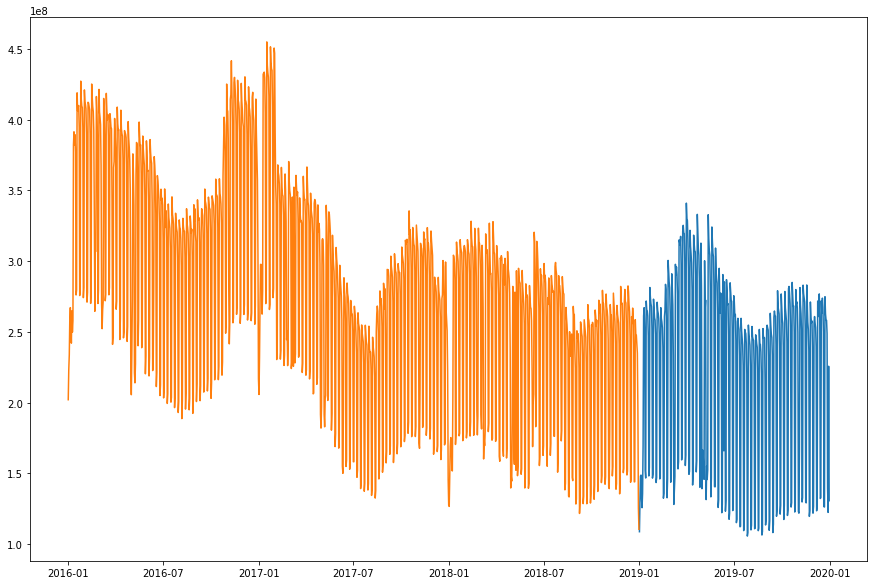

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(data_test.index, data_test['value'])
plt.plot(data_train.index, data_train['value'])
plt.plot(data_test.index, result.numpy())
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
def running_mean_std(x, N, mean_, std_):
    x_for_mean = np.insert(x, 0, np.array([mean_] * (20 + 1)).reshape(-1))
    mean = pd.Series(x_for_mean).rolling(window=N).mean().to_numpy()[N - 1:]
    std = pd.Series(x).rolling(window=N).std().to_numpy()[N - 1:]
    std = np.insert(std, 0, np.array([std_] * (20 + 1)).reshape(-1))
    # cumsum = np.cumsum(np.insert(x, 0, np.array([stats.mean] * (20 + 1)).reshape(-1)))
    # mean = (cumsum[N:] - cumsum[:-N]) / float(N)
    return np.dstack((mean, std)).squeeze()

In [ ]:
class LogDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.mean_std = running_mean_std(data.to_numpy().reshape(-1), 365, stats.mean, stats.std)
        self.data = data
        self._len = data.shape[0]
        
    def __len__(self):
        return self._len
    
    def __getitem__(self, idx):
        return np.append(np.array([idx, idx**2, idx**3]), self.mean_std[idx]), self.mean_std[idx + 1]

lg_dataset = LogDataset(data_train)
lg_dl = DataLoader(lg_dataset, 1096)

In [ ]:
reg_model = LinearRegression()
for x, y in lg_dl:
  reg_model.fit(x, y)

In [ ]:
np.repeat(lg_dataset.mean_std[-1:], 365, axis=0).T

In [ ]:
result_for_correcting_mean_std = torch.cat(result).squeeze()
result_for_correcting_mean_std = result_for_correcting_mean_std * torch.tensor(stats.std) + torch.tensor(stats.mean)

In [ ]:
result_for_correcting_mean_std

In [ ]:
rms = running_mean_std(result_for_correcting_mean_std.numpy(), 20, lg_dataset[-1][0][3], lg_dataset[-1][0][4])
rms = rms[:-2]

In [ ]:
rms.shape

(365, 2)

In [ ]:
x = np.arange(1096, 1096 + 365)
x = np.dstack((x, x**2, x**3, rms.T[0], np.repeat(lg_dataset.mean_std[-1:], 365, axis=0).T[1])).squeeze()
x.shape

(365, 5)

In [ ]:
result_mean_std = reg_model.predict(x)

In [ ]:
result = torch.cat(result).squeeze()
result = result * torch.tensor(lg_dataset[-1][0][4]) + torch.tensor(lg_dataset[-1][0][3])
result_frame = data_test.copy()
result_frame['value'] = result
result_frame.rename(columns={'value': 'hits'})
result_frame

,value
date,
2019-01-01,171836144.0
2019-01-02,177013696.0
2019-01-03,183113840.0
2019-01-04,181911888.0
2019-01-05,139148800.0
...,...
2019-12-27,205388992.0
2019-12-28,134954192.0
2019-12-29,114499168.0


In [ ]:
MAPE(data_test, result_frame)

13.750398632870612

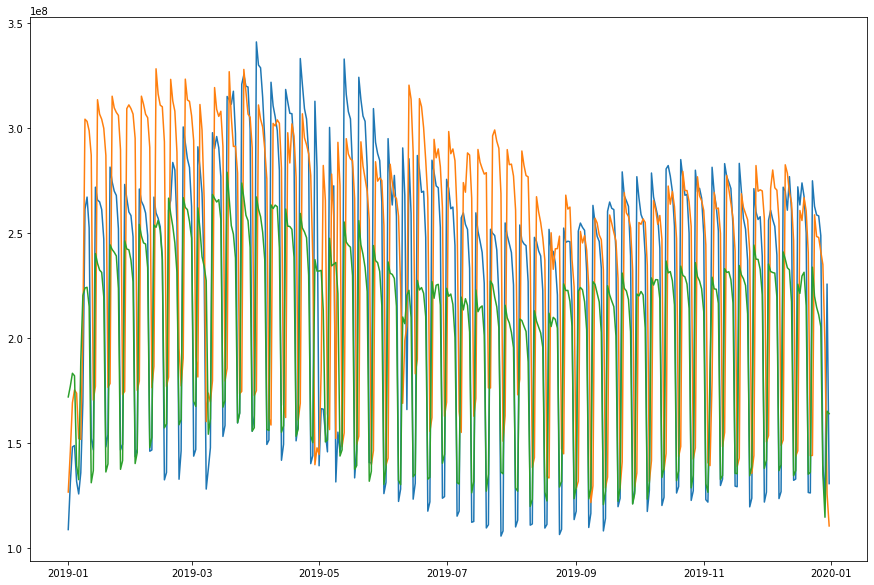

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(data_test.index, data_test['value'])
plt.plot(data_test.index, data_train['value'][731:])
plt.plot(data_test.index, result.numpy())
plt.show()